# Tuning LoRA Hyperparameters - Experiments Vertical, Horizontal and r

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [3]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-231209-0038'

In [4]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-231209-0038 => Completed
Best parameters found: {'sst2-epochs': '14', 'sst2-learning-rate': '0.001446695925631095'}


{'sst2-epochs': 14.0, 'sst2-learning-rate': 0.001446695925631095}

### Vertical / Layers

According to our intuition shouldn't we see that modules closer to the task head have bigger impact on the performance after finetuning?

With finetuning we are adapting the modules in our neural network. The task we want to finetune on is usually something different than we pre-trained on, e.g. we finetune on `sentiment analysis` of emails, while we pre-trained a `masked language model` or `next token` prediction.

In this scenario we would expect that the impact of changes close to the bottom of the network, where the inputs come in, are smaller than the changes a the top of the network. As the understanding of language (bottom) would not be as strongly impacted as what to do with it (top).

So let's put this to the test and only tune some layers from the bottom, from the top, and evenly spread out.



In [5]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, TuningJobCompletionCriteriaConfig
vertical_estimator = PyTorch(**get_default_estimator_parameters())
vertical_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 7
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['12_upper', '12_lower', '12_even', 'all'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = vertical_estimator,
    base_tuning_job_name = 'lora-vertical',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10,
))}


lora_vertical_tuner = HyperparameterTuner(**tuner_parameters)
lora_vertical_tuner.fit(wait=False)

Using provided s3_resource


### Horizontal / Modules

We just submitted some tuning jobs to gauge the vertical (by layer) impact, but what about the horizontal approach to explore the impact of the individual modules, e.g. the query vectors?

There are a lot of interactions between these modules. Hence it would be good to also experiment with the impact of combining these modules. But given the combinatorial explosion of possible trials we stick to validating each module individually, for now. Another important (over-)simplification is to keep in mind is the `r` parameter. The number of parameters of a query vector is very different from the up-projection of the feed-forward layer. But to get a first impression we keep `r` fixed. These are the modules we look into:

Attention:
- q - query, 768 -> 768
- k - key, 768 -> 768
- v - value, 768 -> 768
- o - output, 768 -> 768

Feed Forward:
- u - up projection, i.e. 768 -> 3072
- d - down projection, i.e. 3072 -> 768


In [6]:
horizontal_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q', 'att_k', 'att_v', 'att_o', 'ff_u', 'ff_d'])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_estimator,
    base_tuning_job_name = 'lora-horizontal',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_horizontal_tuner = HyperparameterTuner(**tuner_parameters)
lora_horizontal_tuner.fit(wait=False)

Using provided s3_resource


### Rank

The third angle we explore is chosing `r`. When increasing `r` slowly, at some point we must cross the threshold where `r` becomes higher than the rank of `lora_A` and `lora_B`. Increasing `r` above that level will only make the training more costly with no additional benefit for our model's performance. What is that threshold?

_Sidebar: As we use the Random Search strategy with SageMaker AMT and accordingly no learning is happening in between the trials, theoretically, we could run all trials of this tuning in parallel. Also, we could run this tuning job in parallel to the two tuning jobs before (vertical and horizontal exploration), but we would need to increase our account limit for the training instance types to more than 20, which we haven't. 
So instead, we wait for the other tuning jobs to finish:_

In [7]:
lora_vertical_tuner.wait()

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [8]:
lora_r_estimator = PyTorch(**get_default_estimator_parameters())
lora_r_estimator.set_hyperparameters(**{'sst2-lora-r': 8, 'sst2-lora-config': 'all', **best_hyperparameters})

n_trials = 7
hpt_ranges = {
    'sst2-lora-r': CategoricalParameter([1, 2, 4, 8, 16, 32]),
    'dummy': CategoricalParameter(list(range(0, n_trials))),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = lora_r_estimator,
    base_tuning_job_name = 'lora-r',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_r_tuner = HyperparameterTuner(**tuner_parameters)
lora_r_tuner.fit(wait=False)

Using provided s3_resource


### Analysis

#### Vertical

In [9]:
display_tuning_jobs(lora_vertical_tuner)

!


'lora-vertical-231209-0959'

Tuning job lora-vertical-231209-0959 status: Completed

Number of training jobs with valid objective: 28
Lowest: 0.9323394298553467 Highest 0.9529816508293152


dummy sst2-lora-config                         TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds              TuningJobName  sst2_valid_acc
2       4              all  lora-vertical-231209-0959-026-9101a303         Completed 2023-12-09 10:45:25+01:00 2023-12-09 11:11:46+01:00                      1581.0  lora-vertical-231209-0959        0.952982
3       3              all  lora-vertical-231209-0959-025-014105f3         Completed 2023-12-09 10:45:18+01:00 2023-12-09 11:11:37+01:00                      1579.0  lora-vertical-231209-0959        0.950688
4       2              all  lora-vertical-231209-0959-024-f9593c2c         Completed 2023-12-09 10:45:02+01:00 2023-12-09 11:11:24+01:00                      1582.0  lora-vertical-231209-0959        0.950688
0       6              all  lora-vertical-231209-0959-028-733ff817         Completed 2023-12-09 10:46:52+01:00 2023-12-09 11:13:05+01:00                      1573.0  lora-vertical-231209-0959        0.949541
10      3          12_even  lora-vertical-231209-0959-018-98def3f3         Completed 2023-12-09 10:23:47+01:00 2023-12-09 10:45:09+01:00                      1282.0  lora-vertical-231209-0959        0.948394
9       4          12_even  lora-vertical-231209-0959-019-17a712fc         Completed 2023-12-09 10:23:51+01:00 2023-12-09 10:45:08+01:00                      1277.0  lora-vertical-231209-0959        0.947248
6       0              all  lora-vertical-231209-0959-022-da2db2ad         Completed 2023-12-09 10:45:09+01:00 2023-12-09 11:11:27+01:00                      1578.0  lora-vertical-231209-0959        0.946101
11      2          12_even  lora-vertical-231209-0959-017-ff39e33c         Completed 2023-12-09 10:22:22+01:00 2023-12-09 10:43:48+01:00                      1286.0  lora-vertical-231209-0959        0.946101
1       5              all  lora-vertical-231209-0959-027-f5a74df0         Completed 2023-12-09 10:45:16+01:00 2023-12-09 11:11:29+01:00                      1573.0  lora-vertical-231209-0959        0.946101
12      1          12_even  lora-vertical-231209-0959-016-7376adc1         Completed 2023-12-09 10:22:14+01:00 2023-12-09 10:43:31+01:00                      1277.0  lora-vertical-231209-0959        0.944954

Cache Hit/Miss: MMMMHHMHMHHMHHHHHHHMMHHHHHHH
O sst2-lora-config


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


The vertical exploration was insightful, but not at all what I expected. 

We have a 12 layers model and compared these four configurations:

- __all__: We finetuned all 12 layers using LoRA. This is just for comparison and has double the amount of parameters than the other combinations.
- __lower__: We only finetuned adapters for the 6 lowest layers, closest to the inputs.
- __upper__: We only finetuned adapters for the 6 top layers, closest to the task.
- __even__: We only finetuned adapters for 6 layers, evenly spread out over. 

For our task `sentiment analysis` it appeared reasonable to me that a lot of the interpretation of the inputs could be close to the task head, and is not so much dependent on individual words being meaningful on their own. If that were the case then __upper__ should have outperformed __lower__. __Even__ was the best scenario. But even this scenario was not able to outperform __all__ with double the amount of parameters. 

If you feel inclined, and you ran this notebook for yourself, interact with it. You can select the scenario that is interesting to you and see how the results change. One notable find is that when selecting __upper__ the GPU memory utilization (`gpu_memory`) goes down from 80+% to 55%. Likely because the gradients then only have to be calculated for a relatively short path, just for the classifier and the upper layers. 

Also checkout how the training speed (`train_samples_sec`).

.........................................................................................................................................................................................................................................................................................................................................................................................................................!


'lora-horizontal-231209-0959'

Tuning job lora-horizontal-231209-0959 status: Completed

Number of training jobs with valid objective: 42
Lowest: 0.9277523159980774 Highest 0.9483944773674011


dummy sst2-lora-config                           TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                TuningJobName  sst2_valid_acc
3       3             ff_d  lora-horizontal-231209-0959-039-d3ba8254         Completed 2023-12-09 11:05:40+01:00 2023-12-09 11:25:56+01:00                      1216.0  lora-horizontal-231209-0959        0.948394
2       4             ff_d  lora-horizontal-231209-0959-040-2fc59081         Completed 2023-12-09 11:06:02+01:00 2023-12-09 11:26:19+01:00                      1217.0  lora-horizontal-231209-0959        0.947248
11      2             ff_u  lora-horizontal-231209-0959-031-e7eb874f         Completed 2023-12-09 11:05:26+01:00 2023-12-09 11:25:43+01:00                      1217.0  lora-horizontal-231209-0959        0.944954
8       5             ff_u  lora-horizontal-231209-0959-034-e514238d         Completed 2023-12-09 11:05:13+01:00 2023-12-09 11:25:35+01:00                      1222.0  lora-horizontal-231209-0959        0.943807
13      0             ff_u  lora-horizontal-231209-0959-029-06a3770f         Completed 2023-12-09 10:44:02+01:00 2023-12-09 11:04:19+01:00                      1217.0  lora-horizontal-231209-0959        0.943807
10      3             ff_u  lora-horizontal-231209-0959-032-e760adcc         Completed 2023-12-09 11:05:33+01:00 2023-12-09 11:26:00+01:00                      1227.0  lora-horizontal-231209-0959        0.943807
1       5             ff_d  lora-horizontal-231209-0959-041-44133370         Completed 2023-12-09 11:26:59+01:00 2023-12-09 11:47:16+01:00                      1217.0  lora-horizontal-231209-0959        0.943807
7       6             ff_u  lora-horizontal-231209-0959-035-f36d6216         Completed 2023-12-09 11:05:32+01:00 2023-12-09 11:25:49+01:00                      1217.0  lora-horizontal-231209-0959        0.942661
5       1             ff_d  lora-horizontal-231209-0959-037-6251683c         Completed 2023-12-09 11:05:29+01:00 2023-12-09 11:25:51+01:00                      1222.0  lora-horizontal-231209-0959        0.942661
16      4            att_o  lora-horizontal-231209-0959-026-bdd345ee         Completed 2023-12-09 10:44:02+01:00 2023-12-09 11:03:28+01:00                      1166.0  lora-horizontal-231209-0959        0.942661

Cache Hit/Miss: MMMMHMMMMHMMHHMHMHHHHHHHHHHHHHHHHHHHHHHHHH
O sst2-lora-config


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


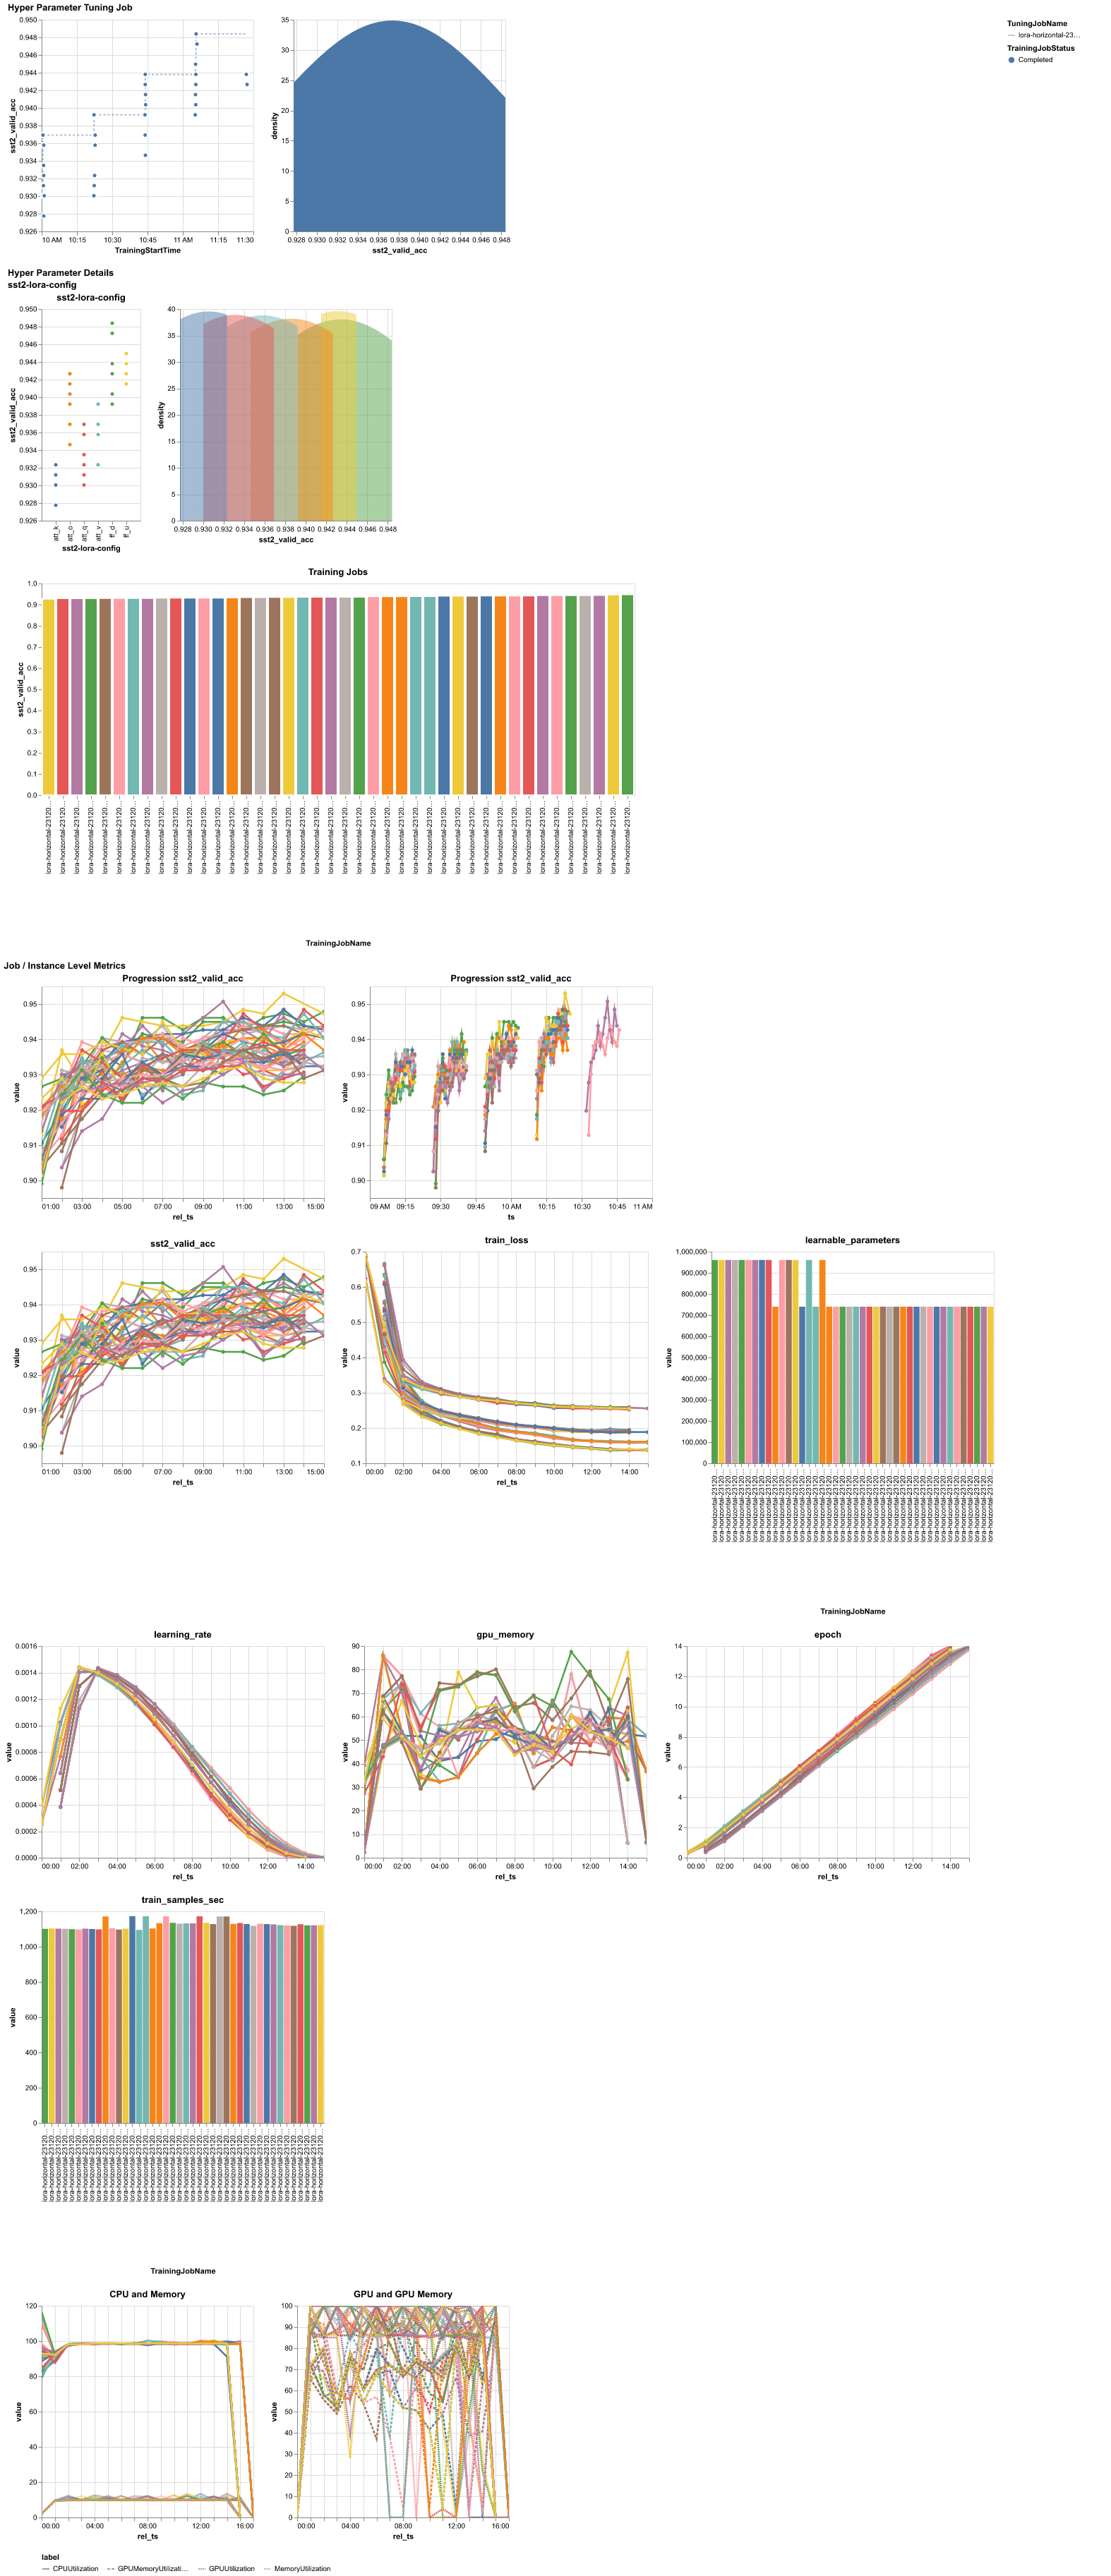

In [10]:
display_tuning_jobs(lora_horizontal_tuner)

#### Horizontal

The __horizontal__ experiments were interesting. The query projection is known to be particularly important for the Transformer, but we see here that finetuning it is not that important. But the output and value projections were impactful, relative to their size.

Both feed forward projections were the most impactful, but we have to keep in mind that they also have a higher parameter count. 

#### R

Reviewing different values of `r` was different than what we hoped for. Higher values of `r`, in theory, should yield the same or better performance. We saw with a larger `r` that we also got more variance, especially with then `r=32`. This was likely a sign of overfitting then.

But as finetuned the `learning rate` in our base tuning job for `r=8` we meanwhile moved away quite with `r=32`. So before we would work on reducing overfitting we would need to tune the `learning rate` / number of `epochs` as for the higher capacity of `r=32`.

............................................................................................................................................................................................................!


'lora-r-231209-1115'

Tuning job lora-r-231209-1115        status: Completed

Number of training jobs with valid objective: 42
Lowest: 0.9300458431243896 Highest 0.9552752375602722


dummy  sst2-lora-r                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  sst2_valid_acc
9       5            4  lora-r-231209-1115-033-9877b096         Completed 2023-12-09 12:47:11+01:00 2023-12-09 13:13:29+01:00                      1578.0  lora-r-231209-1115        0.955275
34      1            2  lora-r-231209-1115-008-c32520b2         Completed 2023-12-09 11:16:59+01:00 2023-12-09 11:43:17+01:00                      1578.0  lora-r-231209-1115        0.950688
13      4           16  lora-r-231209-1115-029-c47bae49         Completed 2023-12-09 12:17:24+01:00 2023-12-09 12:43:47+01:00                      1583.0  lora-r-231209-1115        0.949541
3       6            4  lora-r-231209-1115-039-9f962982         Completed 2023-12-09 12:47:29+01:00 2023-12-09 13:13:47+01:00                      1578.0  lora-r-231209-1115        0.949541
16      4            2  lora-r-231209-1115-026-8f685cb2         Completed 2023-12-09 12:17:21+01:00 2023-12-09 12:43:34+01:00                      1573.0  lora-r-231209-1115        0.948394
21      3            4  lora-r-231209-1115-021-d9a5465d         Completed 2023-12-09 12:17:09+01:00 2023-12-09 12:43:27+01:00                      1578.0  lora-r-231209-1115        0.947248
37      0           16  lora-r-231209-1115-005-1f3910af         Completed 2023-12-09 11:17:08+01:00 2023-12-09 11:43:23+01:00                      1575.0  lora-r-231209-1115        0.947248
32      1            8  lora-r-231209-1115-010-ac535e9e         Completed 2023-12-09 11:16:57+01:00 2023-12-09 11:43:20+01:00                      1583.0  lora-r-231209-1115        0.947248
25      2           16  lora-r-231209-1115-017-fb70658b         Completed 2023-12-09 11:47:39+01:00 2023-12-09 12:13:42+01:00                      1563.0  lora-r-231209-1115        0.947248
1       6           16  lora-r-231209-1115-041-8679b3ea         Completed 2023-12-09 13:17:32+01:00 2023-12-09 13:43:50+01:00                      1578.0  lora-r-231209-1115        0.947248

Cache Hit/Miss: HHHHHHHHHMHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHM


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


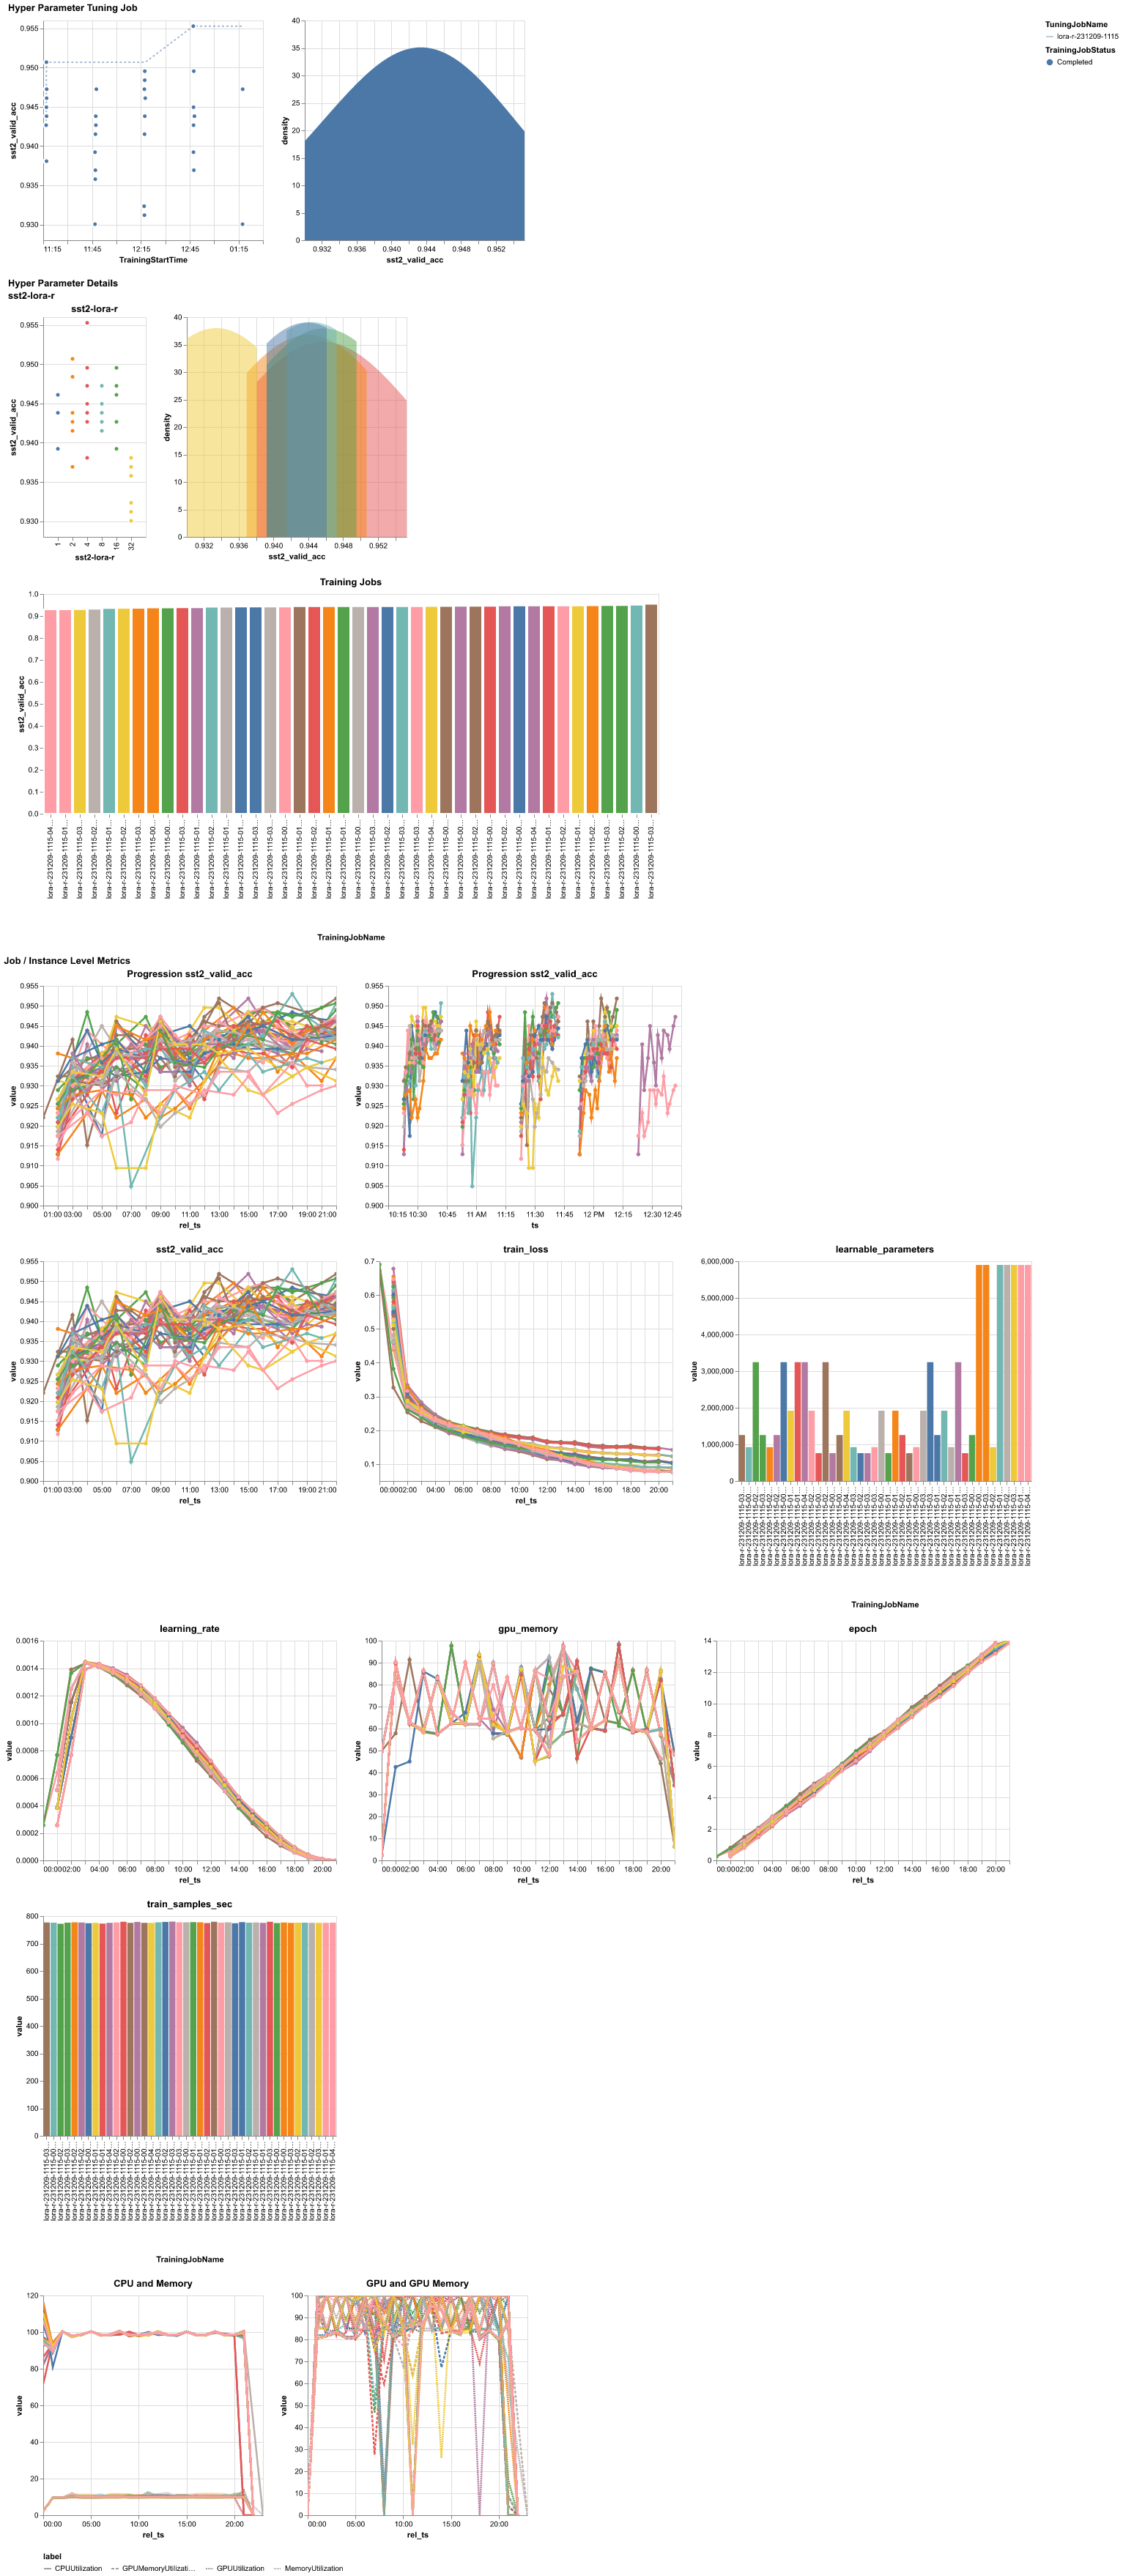

In [12]:
display_tuning_jobs(lora_r_tuner)

### Horizontal Combinations

In [15]:
horizontal_comb_estimator = PyTorch(**get_default_estimator_parameters())
horizontal_comb_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 7
hpt_ranges = {
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter(['att_q+ff_u','att_k+ff_u','att_v+ff_u', 'att_o+ff_u']) 
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = horizontal_comb_estimator,
    base_tuning_job_name = 'lora-horiz-comb',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}

lora_horiz_comb_tuner = HyperparameterTuner(**tuner_parameters)
lora_horiz_comb_tuner.fit(wait=False)

Using provided s3_resource


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


'lora-horiz-comb-231209-1722'

Tuning job lora-horiz-comb-231209-1722 status: Completed

Number of training jobs with valid objective: 28
Lowest: 0.9392201900482178 Highest 0.9518348574638367


dummy sst2-lora-config                           TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds                TuningJobName  sst2_valid_acc
13      0       att_v+ff_u  lora-horiz-comb-231209-1722-015-266a317c         Completed 2023-12-09 17:49:19+01:00 2023-12-09 18:10:56+01:00                      1297.0  lora-horiz-comb-231209-1722        0.951835
15      5       att_k+ff_u  lora-horiz-comb-231209-1722-013-b2f05041         Completed 2023-12-09 17:49:11+01:00 2023-12-09 18:11:55+01:00                      1364.0  lora-horiz-comb-231209-1722        0.951835
7       6       att_v+ff_u  lora-horiz-comb-231209-1722-021-ba5cb8bd         Completed 2023-12-09 18:14:26+01:00 2023-12-09 18:35:57+01:00                      1291.0  lora-horiz-comb-231209-1722        0.950688
24      3       att_q+ff_u  lora-horiz-comb-231209-1722-004-e7dad45b         Completed 2023-12-09 17:23:31+01:00 2023-12-09 17:45:17+01:00                      1306.0  lora-horiz-comb-231209-1722        0.949541
8       5       att_v+ff_u  lora-horiz-comb-231209-1722-020-a523a418         Completed 2023-12-09 17:49:31+01:00 2023-12-09 18:11:07+01:00                      1296.0  lora-horiz-comb-231209-1722        0.949541
10      3       att_v+ff_u  lora-horiz-comb-231209-1722-018-83b1df97         Completed 2023-12-09 17:49:13+01:00 2023-12-09 18:10:50+01:00                      1297.0  lora-horiz-comb-231209-1722        0.949541
14      6       att_k+ff_u  lora-horiz-comb-231209-1722-014-96bbb6d8         Completed 2023-12-09 17:49:01+01:00 2023-12-09 18:10:47+01:00                      1306.0  lora-horiz-comb-231209-1722        0.948394
1       5       att_o+ff_u  lora-horiz-comb-231209-1722-027-5d62a72b         Completed 2023-12-09 18:14:33+01:00 2023-12-09 18:35:44+01:00                      1271.0  lora-horiz-comb-231209-1722        0.948394
2       4       att_o+ff_u  lora-horiz-comb-231209-1722-026-443f9f84         Completed 2023-12-09 18:15:06+01:00 2023-12-09 18:36:20+01:00                      1274.0  lora-horiz-comb-231209-1722        0.947248
23      4       att_q+ff_u  lora-horiz-comb-231209-1722-005-c3c7ff57         Completed 2023-12-09 17:23:52+01:00 2023-12-09 17:45:29+01:00                      1297.0  lora-horiz-comb-231209-1722        0.947248

Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


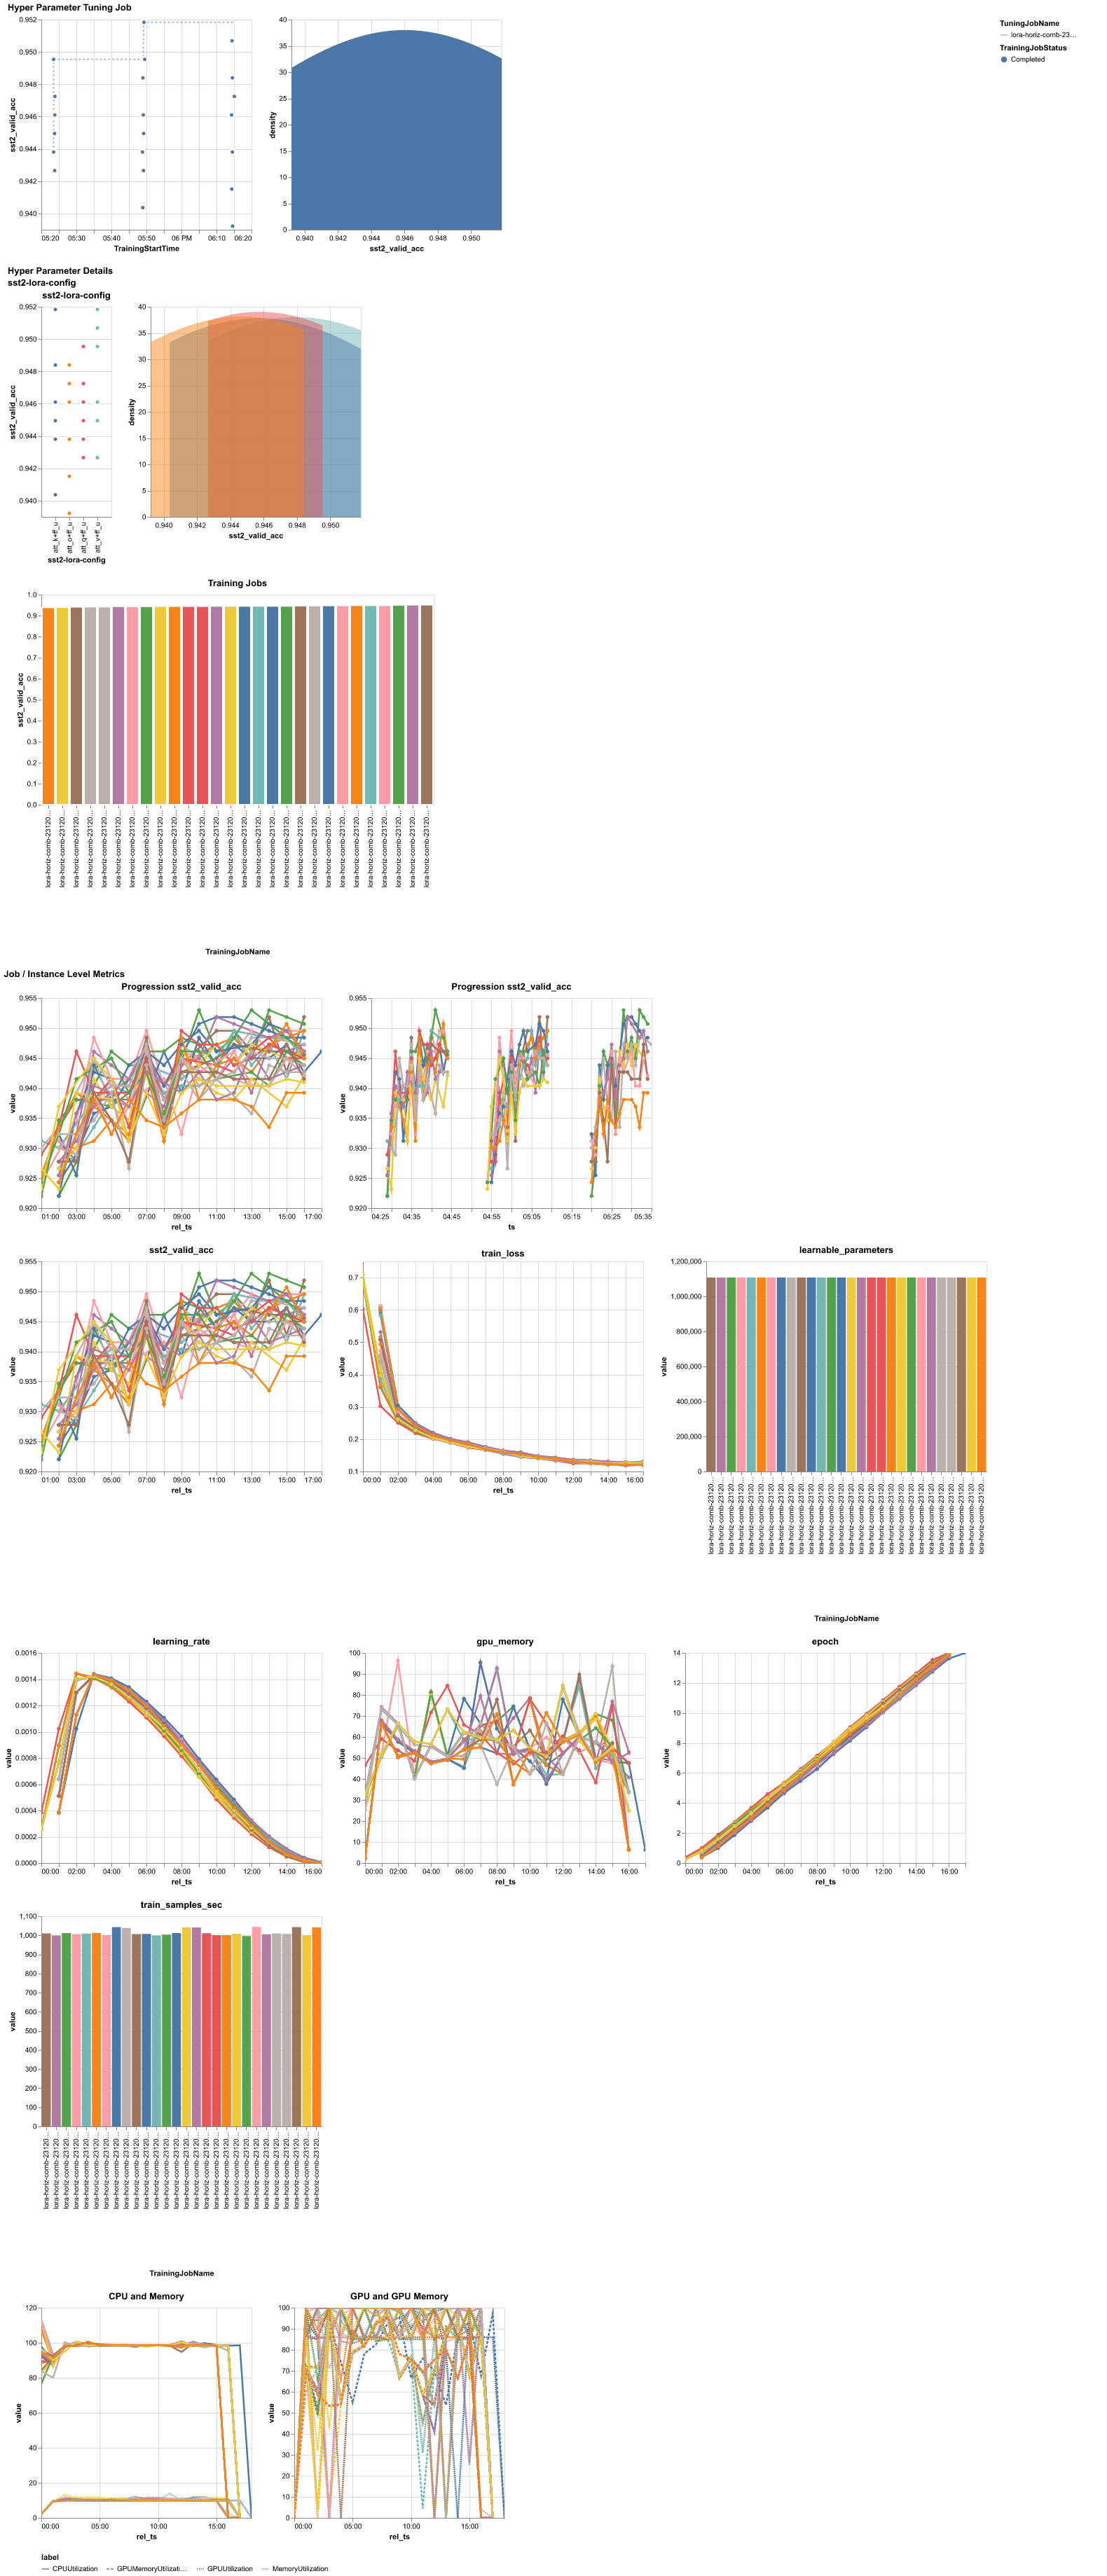

In [16]:
display_tuning_jobs(lora_horiz_comb_tuner)